In [30]:
import torch
import numpy as np
import os, sys
import shutil
import pickle
import cv2

sys.path.insert(0, 'src')
from utils.utils import ensure_dir

sys.path.insert(0, 'setup')
from setup_cifar10 import setup_cifar10 
# import cv2
# print(cv2.__version__)

### Process CIFAR-10 to get rid of bytes

In [3]:
raw_cifar_dir = 'data/cifar-10-batches-py'
processed_cifar_dir = 'data/cifar10-processed'

if not os.path.exists(processed_cifar_dir):
    setup_cifar_10(
        raw_cifar_dir=raw_cifar_dir,
        processed_cifar_dir=processed_cifar_dir)
    print("Processing CIFAR10")
else:
    print("CIFAR-10 already processed at {}".format(processed_cifar_dir))
    

CIFAR-10 already processed at data/cifar10-processed


In [37]:
from torch.utils.data import Dataset
from torchvision import transforms
from utils.visualizations import show_image
class CIFAR10(Dataset):
    def __init__(self,
                 cifar_dir,
                 split,
                 to_tensor=True,
                 normalize=True,
                 means=[0.4914, 0.4822, 0.4465],
                 stds=[0.2471, 0.2435, 0.2616]):
        
        images = []
        labels = []
        assert split in ['train', 'test'], "Invalid split '{}'. Must be 'train' or 'test'".format(split)
        if split == 'train':
            files = ['data_batch_{}'.format(i) for i in range(1,6)]
        else:
            files = ['test_batch']
            
        for file in files:
            path = os.path.join(cifar_dir, file)
            data = pickle.load(open(path, 'rb'))
            cur_images = data['data']
            cur_images = np.reshape(cur_images, (-1, 3, 32, 32))
            images.append(cur_images)
            
            cur_labels = np.array(data['labels'])
            labels.append(cur_labels)
        
        self.images = np.concatenate(images, axis=0)
        self.images = np.transpose(self.images, (0, 2, 3, 1))
        self.labels = np.concatenate(labels, axis=0)
        self.n_samples = len(self.labels)
                
        # Create transformations
        self.transforms = [transforms.ToTensor()]  # changes dims H x W x C -> C x H x W and scales to [0, 1]
        if normalize:
            self.transforms.append(transforms.Normalize(means, stds))
        self.transforms = transforms.Compose(self.transforms)
    
    def __getitem__(self, idx):
        image = self.transforms(self.images[idx])
        label = self.labels[idx]
        return image, label

    def __len__(self):
        return self.n_samples
        
train_dataset = CIFAR10(
    cifar_dir=processed_cifar_dir,
    split='train',
    to_tensor=False,
    normalize=False)

test_dataset = CIFAR10(
    cifar_dir=processed_cifar_dir,
    split='test',
    to_tensor=False,
    normalize=False)


### First use OpenCV's ORB feature descriptor

(128, 128, 3) <class 'numpy.ndarray'>
True


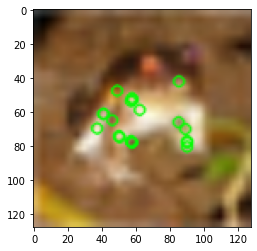

(20, 32)
(128, 128, 3) <class 'numpy.ndarray'>
True


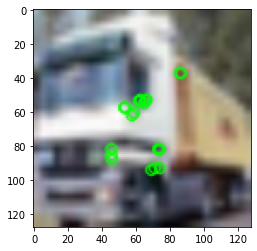

(21, 32)
(128, 128, 3) <class 'numpy.ndarray'>
True


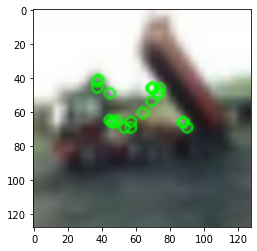

(22, 32)
(128, 128, 3) <class 'numpy.ndarray'>
True


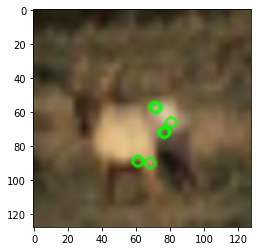

(9, 32)
(128, 128, 3) <class 'numpy.ndarray'>
True


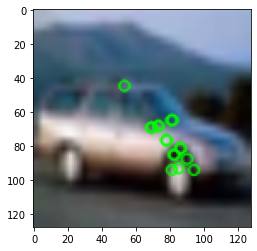

(18, 32)


In [75]:
MAX_FEATURES = 32
RESIZE = (128, 128)
import matplotlib.pyplot as plt

orb = cv2.ORB_create(MAX_FEATURES)
train_keypoints = []
train_descriptors = []
for idx, (image, label) in enumerate(train_dataset):
    if idx == 5:
        break
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    image = cv2.resize(image, RESIZE)
    image = (image * 255.0).astype(np.uint8)
    # image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    print(image.shape, type(image))
    keypoints, descriptors = orb.detectAndCompute(image, None)
    # keypoints_bw, descriptors_bw = orb.detectAndCompute(image_bw, None)
    # print((descriptors == descriptors_bw).all())
    img2 = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
    plt.imshow(img2)
    plt.show()
    print(descriptors.shape)
    train_keypoints.append(keypoints)
    train_descriptors.append(descriptors)

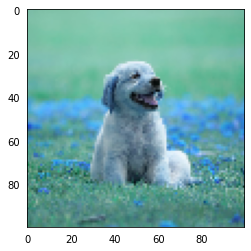

<class 'numpy.ndarray'> (100, 100, 3)
(4, 32)


In [49]:
img = cv2.imread('data/cifar10-processed/dog.jpg')
img = cv2.resize(img, (100, 100))
show_image(img)
print(type(img), img.shape)
keypoints, descriptors = orb.detectAndCompute(img, None)
print(descriptors.shape)